# Plan of Action

# Mount Google Drive & Imports 

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

In [3]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Preparation

## Import Dataset

In [4]:

combined_faces_zip_path = "/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/input/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [5]:

combined_faces_zip_path = "/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/input/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [6]:

train_aug_df = pd.read_csv("/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/input/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/input/images_filenames_labels_test.csv")

## Know your Dataset

In [7]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [8]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [9]:
train_aug_df.shape

(234400, 2)

In [10]:
test_df.shape

(10046, 2)

## Define Age Classes

In [11]:

def class_labels_reassign(age):

    if 1 <= age <= 3:
        return 0
    elif 4 <= age <= 10:
        return 1
    elif 11 <= age <= 17:
        return 2
    elif 18 <= age <= 25:
        return 3
    elif 26 <= age <= 35:
        return 4
    elif 36 <= age <= 46:
        return 5
    elif 47 <= age <= 65:
        return 6
    else:
        return 7

In [12]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [13]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,5
1,/content/content/combined_faces_train_augmente...,71,7
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,3
4,/content/content/combined_faces_train_augmente...,25,3


In [14]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,5
2,/content/content/combined_faces/40_177.jpg,40,5
3,/content/content/combined_faces/36_267.jpg,36,5
4,/content/content/combined_faces/8_349.jpg,8,1


## Organize Dataset

In [15]:

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [16]:

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

# Image Greyscale Function

In [17]:

num_classes = 8

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [18]:

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(512)    

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(512)  

# CNN Architecture

In [19]:

final_cnn = Sequential()

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(GlobalAveragePooling2D())

final_cnn.add(Dense(132, activation='relu'))

final_cnn.add(Dense(8, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [20]:
# Biên dịch kiến trúc CNN đã tạo ở trên.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:

tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/cnn_logs")

In [22]:

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Model Fitting

In [23]:

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=64,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.9851 - accuracy: 0.3151
Epoch 1: val_accuracy improved from -inf to 0.35716, saving model to /content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5
458/458 [==============================] - 350s 708ms/step - loss: 1.9851 - accuracy: 0.3151 - val_loss: 1.7215 - val_accuracy: 0.3572
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 1.6291 - accuracy: 0.3796
Epoch 2: val_accuracy improved from 0.35716 to 0.39578, saving model to /content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5
458/458 [==============================] - 264s 576ms/step - loss: 1.6291 - accuracy: 0.3796 - val_loss: 1.5660 - val_accuracy: 0.3958
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 1.4800 - accuracy: 0.4278
Epoch 3: val_accuracy improved from 0.39578 to 0.45899, saving model to /content/

# Checking Model Performance

In [24]:

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

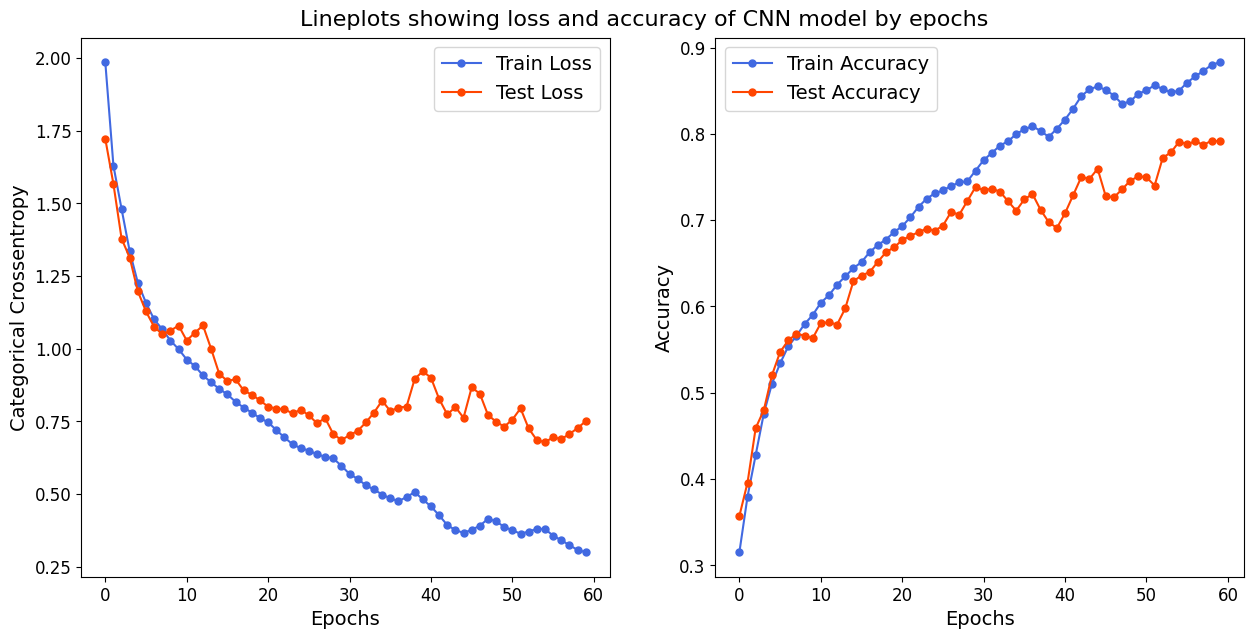

In [25]:

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

plt.savefig('/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

In [26]:

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 3s 136ms/step - loss: 0.7501 - accuracy: 0.7914


In [27]:

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.75
CNN model accuracy 	= 0.791


In [28]:

final_cnn.save(f"/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

### Plotting Confusion Matrix

In [29]:

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

20/20 [==============================] - 4s 200ms/step


In [30]:
# Tạo ma trận nhầm lẫn dựa trên các dự đoán trên.
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[1002,  114,    0,    2,    6,    0,    3,    1],
       [  10,  742,    8,    7,    5,    0,    0,    1],
       [   0,  115,  386,   35,   16,    2,    2,    0],
       [   1,   24,   29, 1062,  185,   16,   11,    1],
       [   1,   22,   19,  387, 1956,  144,   96,   10],
       [   1,   11,    6,   40,  250,  692,  186,    8],
       [   0,    7,    5,   19,   52,   58, 1388,   93],
       [   0,    2,    1,    0,    6,    7,   71,  722]])

In [31]:


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    plt.savefig(f'/content/drive/My Drive/Age_Gender_Emo_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


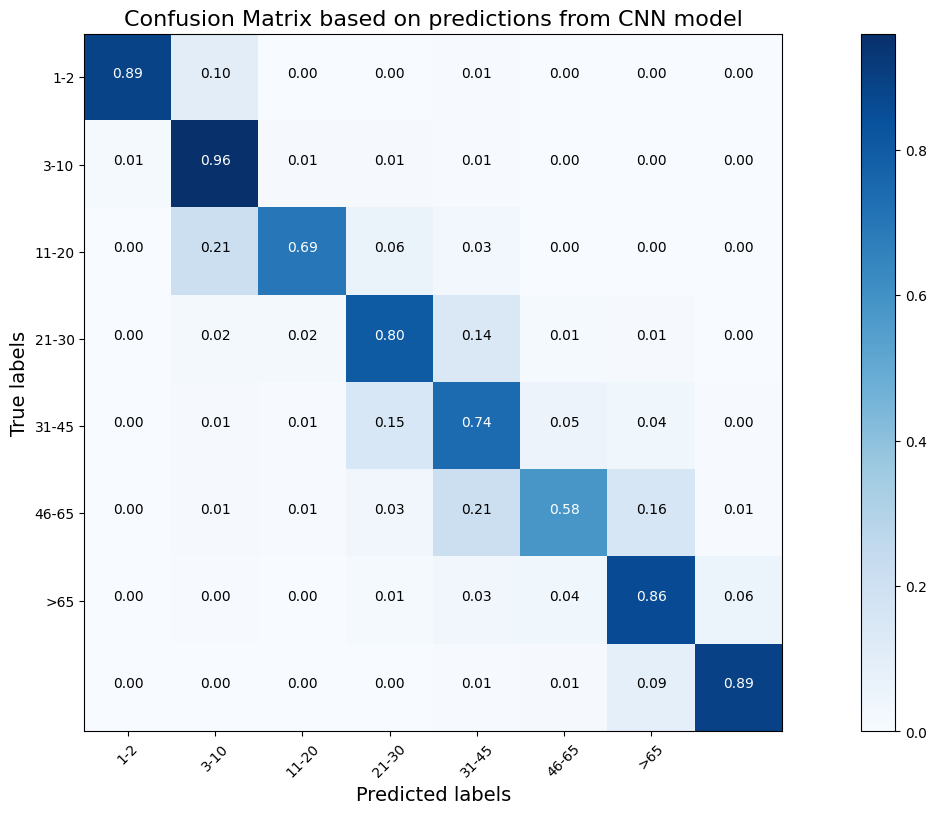

In [32]:

cm_plot_labels = ['1-3', '4-10', '11-17', '18-25', '26-35', '36-46', '47-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()